In [1]:
from pyemma.msm import MaximumLikelihoodMSM, MaximumLikelihoodHMSM
from msmbuilder.cluster import NDGrid
from sklearn.pipeline import Pipeline
import pickle
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from bhmm.hidden.api import forward

/Users/robert_arbon/Google Drive/Research/PyEMMA/pyemma/__init__.py:111: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.1, you have 2.4+905.g9053c678.dirty.
  .format(latest=latest, current=current), category=UserWarning)
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 

In [2]:
traj_paths = glob('../data/100.0pc/*.npy')
X = [np.load(traj_path) for traj_path in traj_paths]
traj128_paths = glob('../data/100.0pc-128split/*.npy')
X128 = [np.load(traj_path) for traj_path in traj_paths]


xmin, xmax = -1.2, 1.2
stride = 10
tau = 30
tau_in_strides = int(tau/stride)
k_opt=4
m_opt = 200

In [3]:
X = [x[::stride] for x in X]
X128 = [x[::stride] for x in X128]

In [4]:
cluster = NDGrid(min=xmin, max=xmax, n_bins_per_feature=m_opt)
dtrajs = cluster.fit_transform(X)

# State selection with BIC/AIC

In [5]:
msminit = MaximumLikelihoodMSM(lag=tau_in_strides)
msminit.fit(dtrajs)

MaximumLikelihoodMSM(connectivity='largest', count_mode='sliding',
           dt_traj='1 step', lag=3, maxerr=1e-08, maxiter=1000000,
           mincount_connectivity='1/n', reversible=True, score_k=10,
           score_method='VAMP2', sparse=False, statdist_constraint=None)

In [40]:
evs = msminit.eigenvalues()
evs = np.abs(evs)
robust_evs = evs[np.where(evs>np.exp(-1))[0]]
robust_evs
maxk = 

array([1.        , 0.96539379, 0.78805857, 0.62708866, 0.0803568 ,
       0.05443509, 0.02512449, 0.02399016, 0.0232292 , 0.02258565])

In [6]:
M = MaximumLikelihoodHMSM(lag=tau_in_strides, nstates=k_opt, 
                          msm_init=msminit, reversible=True, connectivity='largest', observe_nonempty=False)
M.fit(dtrajs)

MaximumLikelihoodHMSM(accuracy=0.001, connectivity='largest',
           dt_traj='1 step', lag=3, maxit=1000, mincount_connectivity=0.25,
           msm_init=MaximumLikelihoodMSM(connectivity='largest', count_mode='sliding',
           dt_traj='1 step', lag=3, maxerr=1e-08, maxiter=1000000,
           mincount_connectivity='1/n', reversible=True, score_k=10,
           score_method='VAMP2', sparse=False, statdist_constraint=None),
           nstates=4, observe_nonempty=False, reversible=True,
           separate=None, stationary=False, stride=1)

In [7]:
M.BIC

6865166.1500042165

In [8]:
M.AIC

6856024.298442959

In [9]:
M.score_params

{'dof': 785,
 'loglike': -3427227.1492214794,
 'numData': 843800,
 'numHiddenStates': 4,
 'numObservedStates': 195}

In [10]:
obs_frames = np.sum([x.shape[0]-tau_in_strides for x in X])
obs_frames

843800

In [11]:
0.5*4*(4-1) + 4 - 1

9.0

In [12]:
4*(195-1)

776

In [13]:
M.BIC - M.AIC

9141.851561257616

In [15]:
785*(np.log(843800)-2)

9141.851561257814

In [16]:
ks = np.arange(2,7)
aics = np.zeros(ks.shape)
bics = np.zeros(ks.shape)
for i,k in enumerate(ks):
    print(k)
    M = MaximumLikelihoodHMSM(lag=tau_in_strides, nstates=k, 
                          msm_init=msminit, reversible=True, connectivity='largest', observe_nonempty=False)
    M.fit(dtrajs)
    aics[i] = M.AIC
    bics[i] = M.BIC
    

2
3
4
5
6


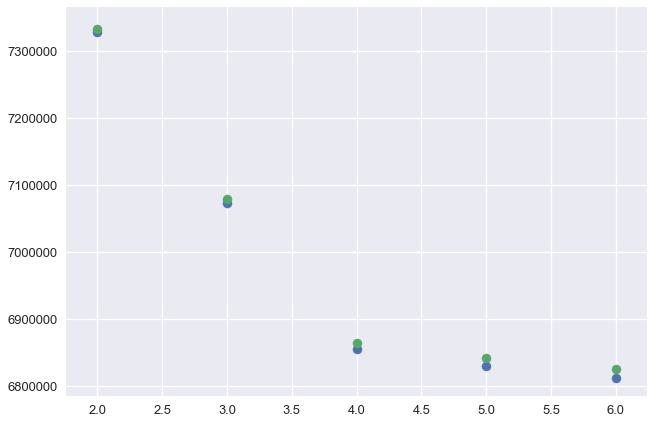

In [19]:
with sns.plotting_context('talk', font_scale=1):
    plt.scatter(ks, aics, label='AIC')
    plt.scatter(ks, bics, label='BIC')

## Cross Validation 

In [24]:
cluster = NDGrid(min=xmin, max=xmax, n_bins_per_feature=m_opt)
dtrajs = cluster.fit_transform(X128)
ks = np.array([2,3,4,5])

In [25]:
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=20)

In [26]:
cv_loglike = np.zeros((ks.shape[0], cv.n_splits))

In [27]:
for kdx, k in enumerate(ks):
    print(k)
    for idx, (train_idx, test_idx) in enumerate(cv.split(dtrajs)):
        train = [dtrajs[i] for i in train_idx]
        test = [dtrajs[i] for i in test_idx]
        print('\t', idx)
        
        # initialize MInit
        Minit = MaximumLikelihoodMSM(lag=tau_in_strides)
        Minit.fit(train)

        # Map new trajectories
        ttrain = Minit.dtrajs_active
        ttest = []
        for x in test:
            try:
                ttest.append(Minit._full2active[x])
            except:
                pass

        # Fit HMM
        M = MaximumLikelihoodHMSM(lag=tau_in_strides, nstates=k, msm_init=Minit, 
                                  reversible=True, connectivity='largest', observe_nonempty=False)
        M.fit(train)
        obs_prob = M.observation_probabilities
        T = M.transition_matrix
        p0 = M.initial_distribution

        # Get log likelihood 
        loglik = 0
        for obs in ttest:
            p_obs = obs_prob[:, obs].T
            loglik += forward(T, p_obs, p0)[0]

        cv_loglike[kdx][idx] = loglik

2
	 0
	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18
	 19
3
	 0
	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18
	 19
4
	 0
	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18
	 19
5
	 0
	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18
	 19


In [28]:
cv_loglike

array([[-361920.75488467, -362196.47858748, -361931.8735299 ,
        -362156.24007553, -362156.34897794, -361842.95419082,
        -362413.94467863, -362356.03219671, -362406.50740255,
        -362312.03538158, -362163.12370404, -362201.59857404,
        -362519.61554442, -361987.5827362 , -362369.85508693,
        -362244.77545397, -362296.28628936, -362211.84920877,
        -362282.48555916, -361925.93151067],
       [-346893.16284486, -345474.68726249, -346124.48420997,
        -345807.76612786, -344532.70977507, -346824.40896572,
        -344905.76129482, -345709.6478392 , -345854.38236829,
        -345059.84886387, -345653.18097428, -344300.36645928,
        -344940.17720303, -344984.7368821 , -344635.85511612,
        -345943.88786775, -346086.66582838, -346262.57062398,
        -344482.23962151, -345682.10229156],
       [-327208.18215647, -327742.32383265, -327118.47898514,
        -327398.76613506, -326979.25373531, -327647.04674324,
        -327403.05874039, -327905.44238094

In [30]:
np.save('cv_loglike.npy', cv_loglike)